# BÁO CÁO BÀI TẬP THỰC HÀNH VÀ ĐỒ ÁN CUỐI KỲ



In [1]:
# import các thư viện
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display
from tqdm import tqdm

In [2]:
# Các biến toàn cục

# thư mục gốc chứa thư mục dữ liệu
szWorkingDir = "/kaggle/input/car-cs114"

# dùng để hiển thị
nNumImgsPerRow = 10
nImgHeight = nImgWidth = 150

In [3]:
# mapping
labels = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8
}
reverse_map_labels = {
    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
}

Đoạn mã bao gồm:

* File csv chứa ảnh lỗi: Không thể đọc được
* File csv chứa thông tin kênh màu, độ trong suốt
* File csv chứa thông tin các ảnh trùng được phát hiện thông qua bài tập Clustering (trong phần này là tập Train-1)
* Và đường dẫn dataset và train-1.csv

In [4]:
path_img = os.path.join(szWorkingDir, "dataset")
error = pd.read_csv(os.path.join(szWorkingDir,"ImageErrors.csv"))
error_paths = error.iloc[:, 0].unique().tolist() # Lấy thông tin đường dẫn ảnh lỗi

In [5]:
csv_dir = os.path.join(szWorkingDir,"car_split/car_split")
#Link train
img_path_train =os.path.join(csv_dir,"CarDataset-Splits-4-Train.csv")
# Những tập hình ảnh data có trong file Public
data_org_path =os.path.join(csv_dir,"CarDataset.csv")
#Đọc File train
data = pd.read_csv(img_path_train)

In [6]:
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2                Others/22520394-22520395.Others.578.jpg           0
3                Others/22521070-22520211.Others.166.jpg           0
4                Others/22520779-22521587.Others.527.jpg           0
...                                                  ...         ...
29385           VinFast/21522373-21522499.VinFast.10.png           8
29386            VinFast/22521692-22521676.VinFast.7.jpg           8
29387  VinFast/22521259-22521213-22521463.VinFast.13.jpg           8
29388  VinFast/22521027-22520195-22521060.VinFast.092...           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[29390 rows x 2 columns]

In [7]:
# Loại bỏ các ảnh có trong error_paths
data = data[~data['ImageFullPath'].isin(error_paths)]
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2                Others/22520394-22520395.Others.578.jpg           0
3                Others/22521070-22520211.Others.166.jpg           0
4                Others/22520779-22521587.Others.527.jpg           0
...                                                  ...         ...
29385           VinFast/21522373-21522499.VinFast.10.png           8
29386            VinFast/22521692-22521676.VinFast.7.jpg           8
29387  VinFast/22521259-22521213-22521463.VinFast.13.jpg           8
29388  VinFast/22521027-22520195-22521060.VinFast.092...           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[29372 rows x 2 columns]

In [8]:
# Đọc file chứa thông tin ảnh trùng
duplicates_df = pd.read_csv('/kaggle/input/car-cs114/CheckDuplicate/CheckDuplicate_Train_4.csv')
duplicates_df

ImageFullPath  ClusterID
0                Others/22521492-22521599.Others.49.jpg          0
1                Others/22521492-22521599.Others.50.jpg          0
2                 Others/22521425-22520318.Others.5.jpg          1
3       Others/22521463-22521213-22521259.Others.26.jpg          1
4               Others/22521492-22521599.Others.107.jpg          2
...                                                 ...        ...
1420  VinFast/22521027-22520195-22521060.VinFast.074...        149
1421   VinFast/22521259-22521213-22521463.VinFast.5.jpg        150
1422          VinFast/22521070-22520211.VinFast.193.jpg        150
1423           VinFast/22520477-22520490.VinFast.20.jpg        151
1424  VinFast/22521027-22520195-22521060.VinFast.025...        151

[1425 rows x 2 columns]

In [9]:
# Lấy các nhóm ảnh trùng
duplicate_groups = duplicates_df.groupby('ClusterID')['ImageFullPath'].agg(list)

# Xử lý từng nhóm trùng
for group in duplicate_groups:
    if len(group) > 1:
        # Chọn ngẫu nhiên 1 ảnh giữ lại
        keep_image = np.random.choice(group, 1)[0]
        # Lấy các ảnh cần loại bỏ
        remove_images = [img for img in group if img != keep_image]
        # Loại bỏ ảnh trùng trong DataFrame
        data = data[~data['ImageFullPath'].isin(remove_images)]

data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2                Others/22520394-22520395.Others.578.jpg           0
3                Others/22521070-22520211.Others.166.jpg           0
4                Others/22520779-22521587.Others.527.jpg           0
...                                                  ...         ...
29383  VinFast/22521027-22520195-22521060.VinFast.090...           8
29384           VinFast/22521560-22521614.VinFast.23.jpg           8
29385           VinFast/21522373-21522499.VinFast.10.png           8
29388  VinFast/22521027-22520195-22521060.VinFast.092...           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[28099 rows x 2 columns]

Train and val data

In [10]:
img = data['ImageFullPath']
label = data['CategoryID']
image = [os.path.join(path_img, i) for i in img]
len(image)

28099

Chia tập train và val (Train 80%, Val 20%)

In [11]:
train_X, val_X, train_Y, val_Y = train_test_split(image, label, test_size=0.2, random_state=30)
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)
print(train_label_count)
print(val_label_count)

Counter({6: 4230, 7: 3716, 0: 2696, 3: 2117, 2: 2102, 4: 2077, 1: 2016, 5: 1845, 8: 1680})
Counter({6: 1028, 7: 868, 0: 687, 1: 548, 2: 541, 3: 530, 4: 511, 5: 475, 8: 432})


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


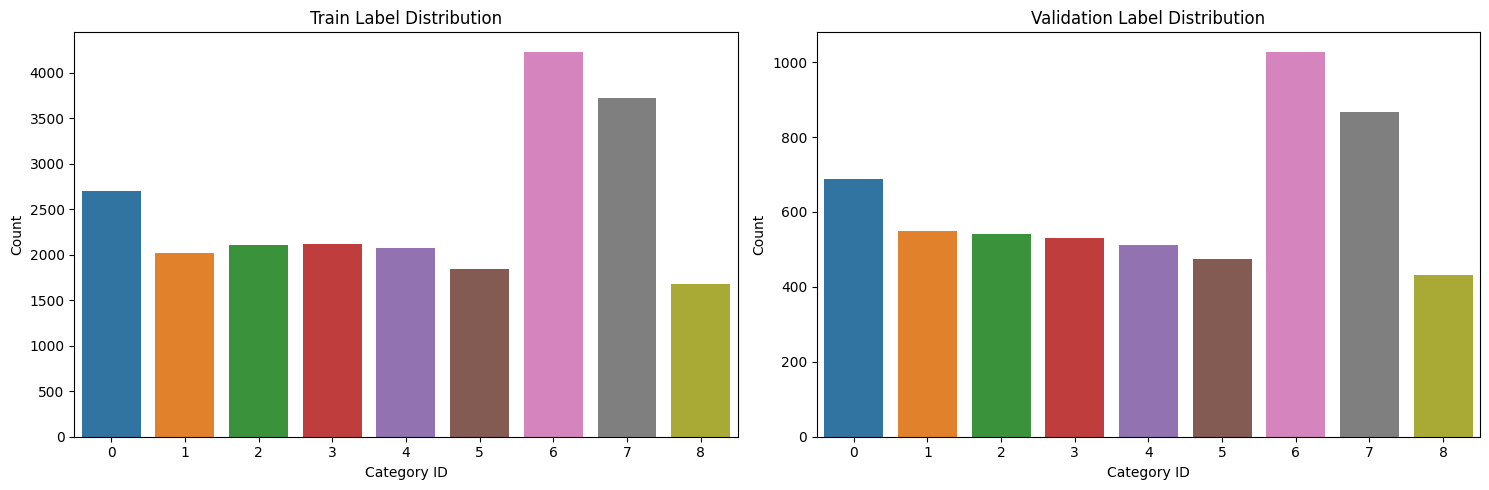

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Giả sử 'train_Y' và 'val_Y' là nhãn của dữ liệu huấn luyện và kiểm tra
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)

# Vẽ biểu đồ phân phối nhãn cho cả train và val
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution
sns.barplot(x=list(train_label_count.keys()), y=list(train_label_count.values()), ax=axes[0])
axes[0].set_title('Train Label Distribution')
axes[0].set_xlabel('Category ID')
axes[0].set_ylabel('Count')

# Validation label distribution
sns.barplot(x=list(val_label_count.keys()), y=list(val_label_count.values()), ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Category ID')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Dùng để hiển thị

* nNumImgsPerRow = 10
* nImgHeight = nImgWidth = 150

In [13]:
# Số lượng các danh mục hoặc lớp ảnh khác nhau
classes = 9

# Kích thước của mỗi ảnh trong hình
figsize_per_image = (2, 2)

def display_images(data):

    images = {}

    # Lặp qua từng lớp
    for Class in range(classes):
        # Lọc dataframe theo lớp hiện tại
        class_df = data[data['CategoryID'] == Class]

        # Lấy ngẫu nhiên các đường dẫn ảnh từ dataframe đã lọc
        sample_images = class_df.sample(n=min(nNumImgsPerRow, len(class_df)))['ImageFullPath']

        # Tải và thay đổi kích thước từng ảnh được chọn, lưu vào dictionary `images`
        images[Class] = [cv2.resize(cv2.imread(os.path.join(path_img, img_path), cv2.IMREAD_COLOR), (nImgWidth, nImgHeight)) for img_path in sample_images]

    # Tính toán kích thước hình dựa trên số lượng ảnh và số lớp
    figsize = (figsize_per_image[0] * (nNumImgsPerRow + 1), figsize_per_image[1] * classes)

    # Tạo các ô con (subplot) với số dòng là số lớp và số cột là `NumImgsPerRow + 1`
    fig, axes = plt.subplots(classes, nNumImgsPerRow + 1, figsize=figsize)

    # Hiển thị ảnh
    for i in tqdm(range(classes)):
        for j in range(nNumImgsPerRow + 1):
            # Lấy ô subplot hiện tại
            ax = axes[i, j]

            # Nếu là cột đầu tiên, hiển thị nhãn lớp
            if j == 0:
                ax.text(0.5, 0.5, f'{reverse_map_labels[i]}', va='center', ha='center', transform=ax.transAxes, fontsize=14, fontweight='bold')
            # Nếu không, hiển thị ảnh nếu tồn tại
            elif j-1 < len(images[i]):
                ax.imshow(cv2.cvtColor(images[i][j-1], cv2.COLOR_BGR2RGB))

            # Ẩn các đường viền trục để giao diện gọn gàng hơn
            ax.axis('off')

    # Điều chỉnh bố cục để tránh chồng lấn và hiển thị hình
    plt.tight_layout()
    plt.show()

100%|██████████| 9/9 [00:00<00:00, 104.94it/s]


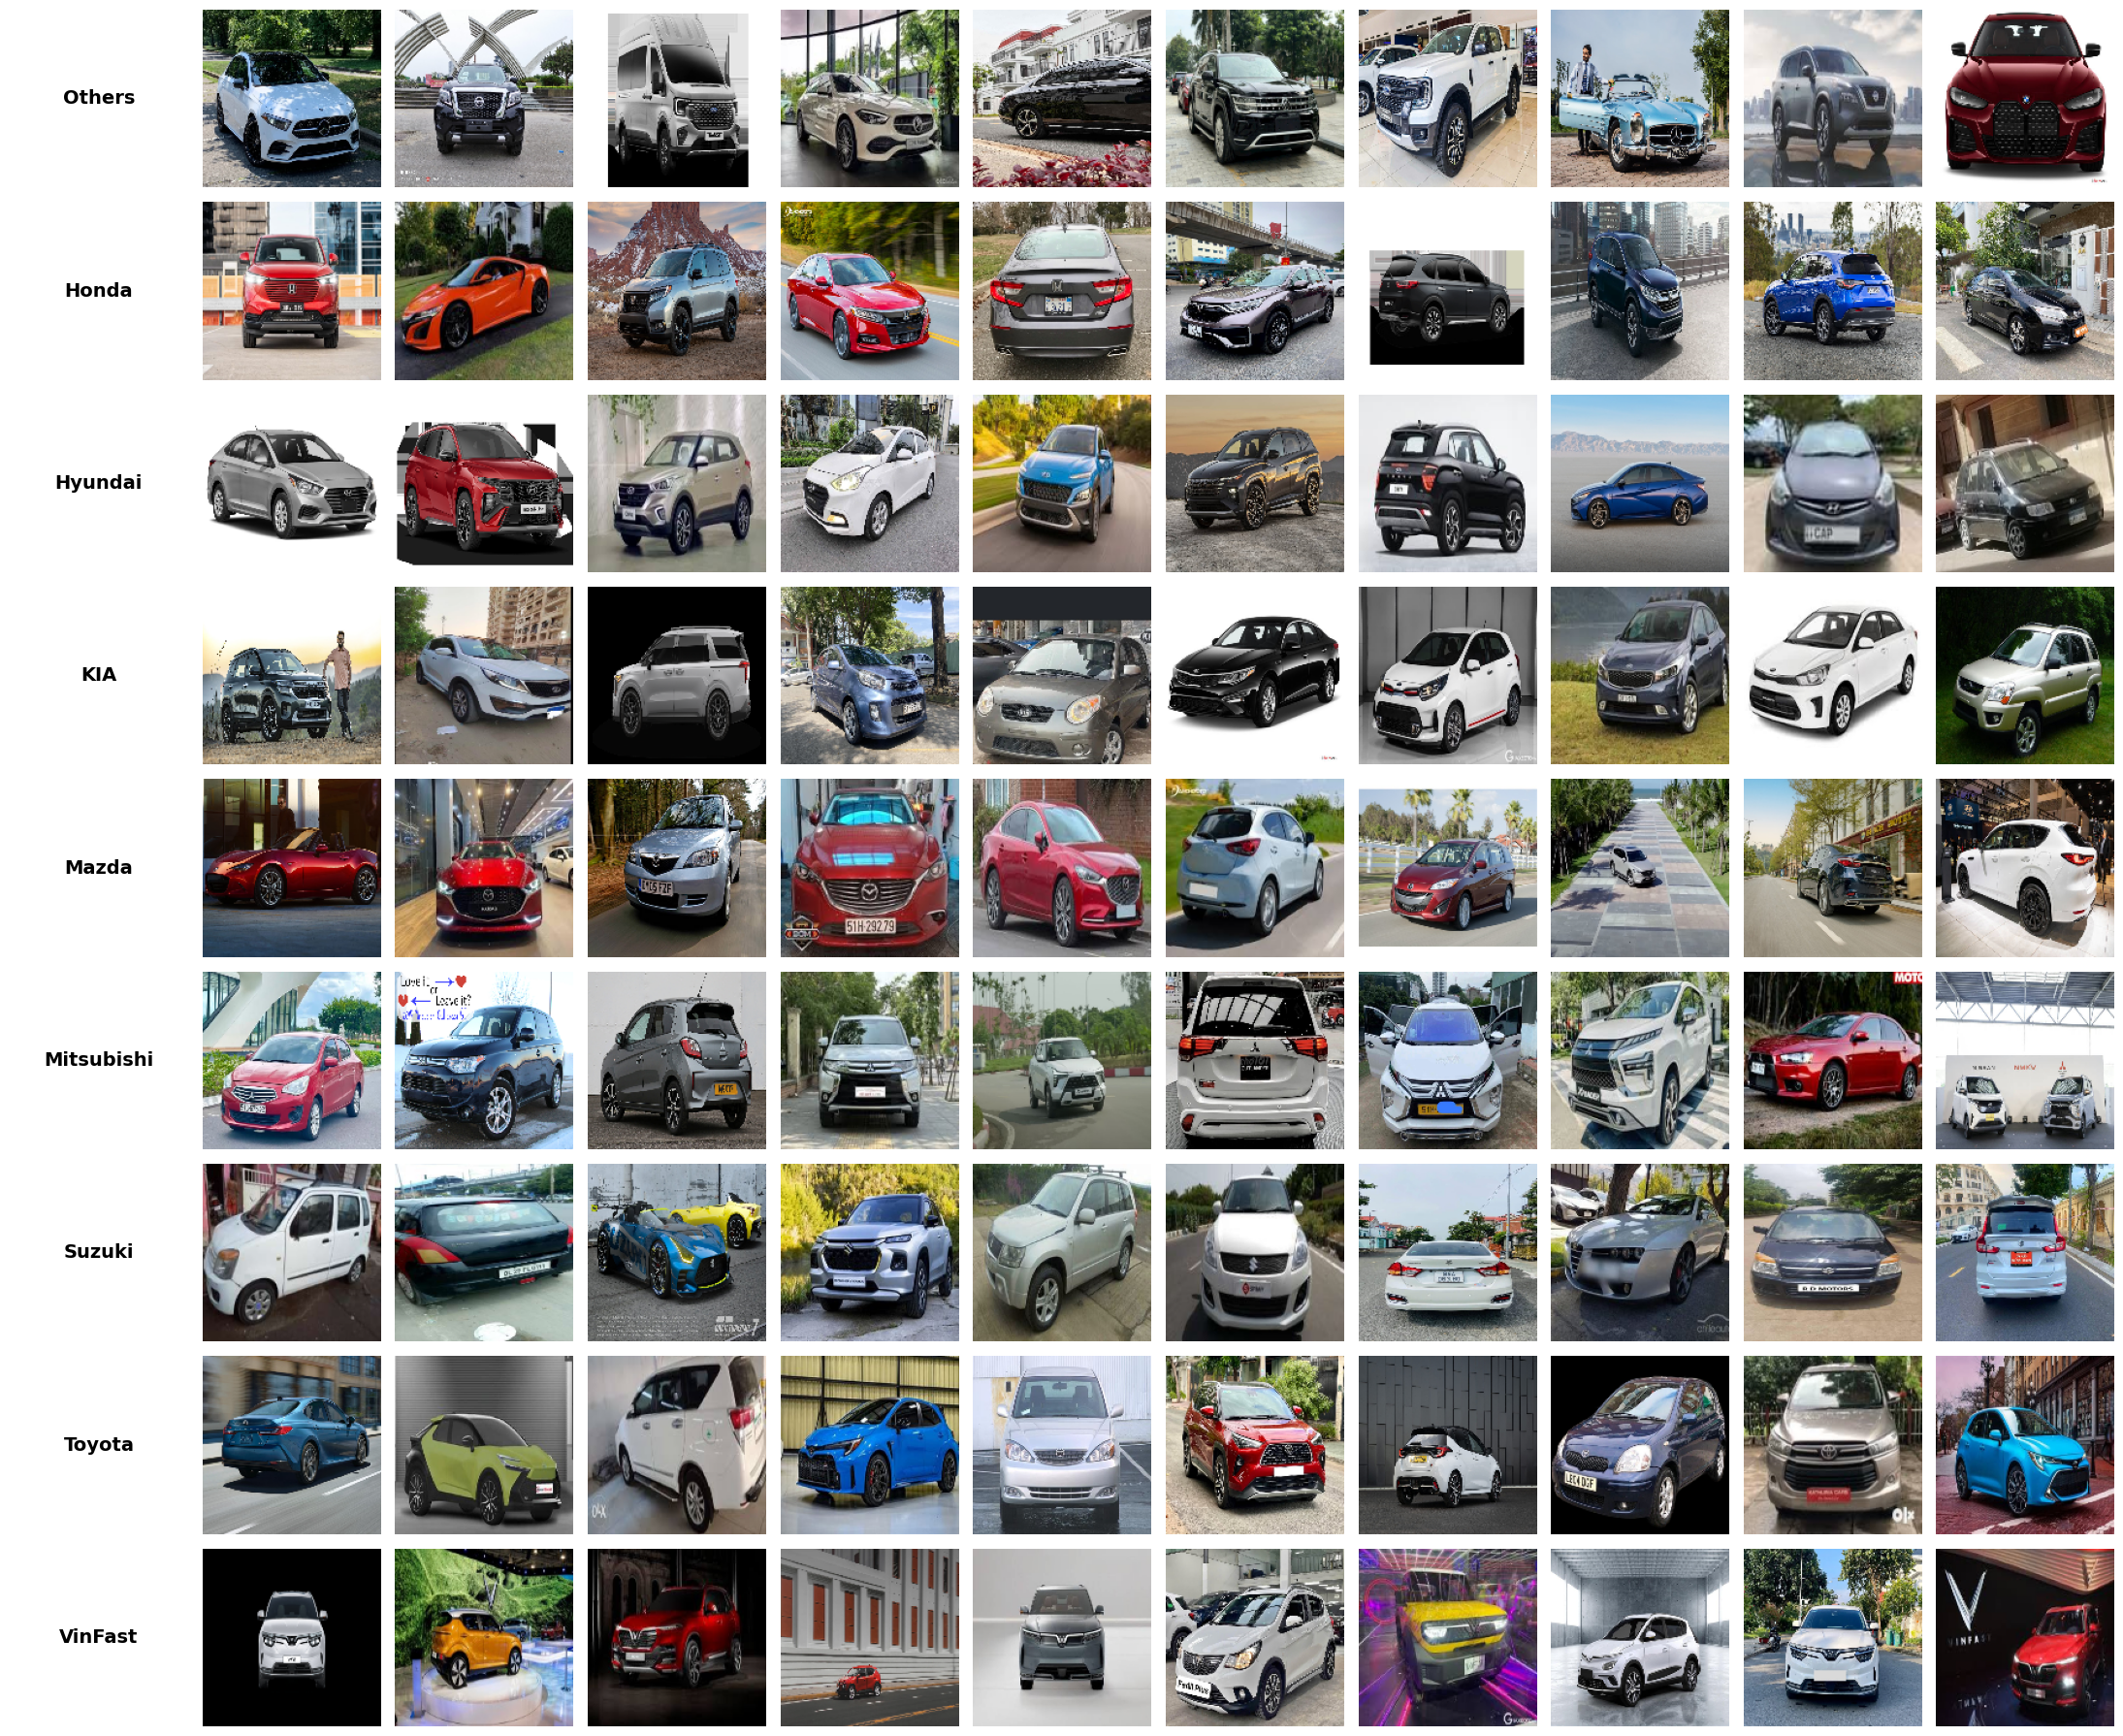

In [14]:
display_images(data)

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(224),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.RandomHorizontalFlip(),  # Lật ngang ảnh ngẫu nhiên để tăng cường dữ liệu
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(224),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
}

In [16]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Mở ảnh bằng Pillow
        img_pil = Image.open(img_path)
        # Chuyển đổi sang RGB nếu không phải
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')

        # Áp dụng các phép biến đổi
        if self.transform:
            img_pil = self.transform(img_pil)

        return img_pil, label

In [17]:
train_set = CustomDataset(train_X, train_Y, transform=data_transforms['train'])
val_set = CustomDataset(val_X,val_Y, transform=data_transforms['val'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True,num_workers=1)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, pin_memory=True,num_workers= 1)

In [18]:
train_set[0]

(tensor([[[ 1.1358,  1.1187,  1.0844,  ...,  1.4269,  1.4269,  1.4098],
          [ 1.1187,  1.1015,  1.0673,  ...,  1.3413,  1.3927,  1.4098],
          [ 1.1015,  1.0844,  1.0673,  ...,  1.2043,  1.3070,  1.3584],
          ...,
          [ 0.0741, -0.0287, -0.1486,  ...,  0.4508,  0.4508,  0.8104],
          [ 0.1939,  0.2453,  0.0569,  ..., -0.0458, -0.1828,  0.2967],
          [ 0.1597,  0.1768, -0.0116,  ...,  0.0398, -0.1143,  0.1254]],
 
         [[ 1.2381,  1.2206,  1.2031,  ...,  1.3782,  1.3606,  1.3606],
          [ 1.2206,  1.2031,  1.2031,  ...,  1.3256,  1.3606,  1.3606],
          [ 1.2031,  1.2031,  1.2031,  ...,  1.2556,  1.3081,  1.3431],
          ...,
          [ 0.1001,  0.0126, -0.1099,  ...,  0.4678,  0.4678,  0.8354],
          [ 0.2402,  0.2927,  0.1176,  ...,  0.0126, -0.1450,  0.2927],
          [ 0.1877,  0.2052,  0.0476,  ...,  0.0651, -0.1099,  0.1352]],
 
         [[ 1.3677,  1.3502,  1.3328,  ...,  1.4374,  1.4200,  1.4200],
          [ 1.3502,  1.3328,

In [19]:
val_set[0]

(tensor([[[-1.1075, -0.7308, -0.6794,  ..., -0.7479, -0.8164, -0.7822],
          [-1.1760, -0.8678, -0.7479,  ..., -0.7650, -0.7993, -0.7308],
          [-1.1760, -1.1075, -1.0048,  ..., -0.7308, -0.7479, -0.6623],
          ...,
          [ 0.5193,  0.4679,  0.4166,  ...,  0.4337,  0.4337,  0.4166],
          [ 0.4337,  0.4508,  0.3309,  ...,  0.5193,  0.5707,  0.3309],
          [ 0.3309,  0.3309,  0.3823,  ...,  0.3994,  0.4337,  0.3481]],
 
         [[-0.9153, -0.5301, -0.4776,  ..., -0.7052, -0.7752, -0.7402],
          [-0.9853, -0.6702, -0.5476,  ..., -0.7227, -0.7577, -0.6877],
          [-0.9853, -0.9153, -0.8102,  ..., -0.6877, -0.7052, -0.6176],
          ...,
          [ 0.6604,  0.6078,  0.5553,  ...,  0.5728,  0.5728,  0.5553],
          [ 0.5728,  0.5903,  0.4678,  ...,  0.6604,  0.7129,  0.4678],
          [ 0.4678,  0.4678,  0.5203,  ...,  0.5378,  0.5728,  0.4853]],
 
         [[-0.6193, -0.2358, -0.1835,  ..., -0.4973, -0.5670, -0.5321],
          [-0.6890, -0.3753,

Show 16 ảnh trong 1 batch

In [20]:
def show_batch_images(images, labels, mean, std, max_images=16):
    # Ensure mean and std are numpy arrays
    mean = np.array(mean)
    std = np.array(std)

    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), max_images)):
        image = images[i].numpy().transpose((1, 2, 0))  # Transpose tensor from (C, H, W) to (H, W, C)

        # Denormalize
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

        plt.subplot(4, 4, i + 1)  # 4 rows and 4 columns
        plt.imshow(image)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

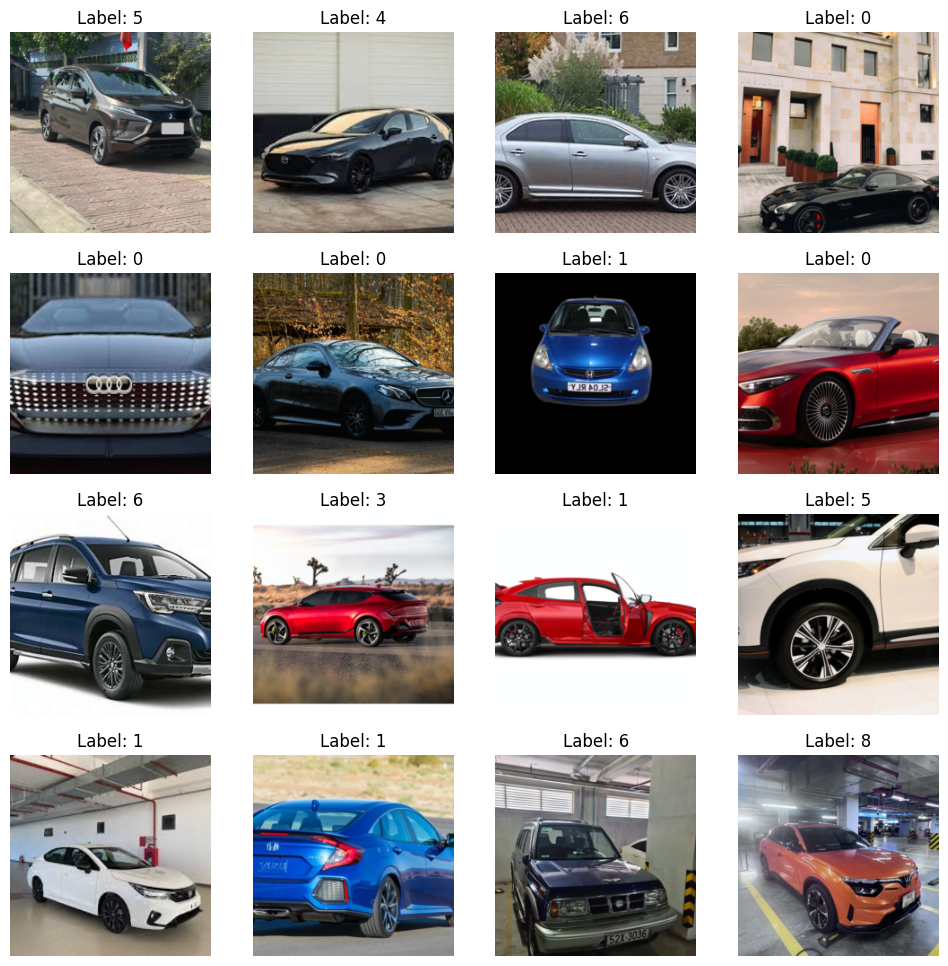

In [21]:
batch_images, batch_labels = next(iter(train_loader))  # Replace data_loader with your actual DataLoader
show_batch_images(batch_images, batch_labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [22]:
from tempfile import TemporaryDirectory
import torch.optim as optim
import time
import torchvision.models as models
from torch.optim import lr_scheduler

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
import torch
# Kiểm tra GPU memory trước khi load model
print(f"GPU memory before model: {torch.cuda.memory_allocated()/1e9:.2f} GB")
torch.cuda.empty_cache()

GPU memory before model: 0.00 GB


In [25]:
model_ft = torchvision.models.regnet_y_128gf(weights='RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_LINEAR_V1')

# Freeze all layers except the last fully connected layer
for param in model_ft.parameters():
    param.requires_grad = False


# Replace the last fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 9)
# Move model to device (GPU if available)
for param in model_ft.fc.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_lc_swag-cbe8ce12.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_lc_swag-cbe8ce12.pth
100%|██████████| 2.40G/2.40G [00:25<00:00, 100MB/s] 


In [26]:
model_ft

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [27]:
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define learning rate scheduler (decay LR by a factor of 0.1 every 7 epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, train_loader=None, val_loader=None, device=None):
    since = time.time()
    best_acc = 0.0
    best_model_params_path = '/kaggle/working/regnet_04.pt'
    
    # Histories
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    # Grad scaler for mixed precision
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch+1}/{num_epochs}'):
                try:
                    # Move input and labels to device
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Verify shapes and values
                    assert inputs.shape[1:] == (3, 224, 224), f"Wrong input shape: {inputs.shape}"
                    assert labels.shape[0] == inputs.shape[0], f"Batch size mismatch: {labels.shape} vs {inputs.shape}"
                    assert torch.all(labels >= 0) and torch.all(labels < 9), f"Labels out of range: {labels.min()}-{labels.max()}"
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == 'train'):
                        with torch.amp.autocast('cuda'):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            _, preds = torch.max(outputs, 1)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                except Exception as e:
                    print(f"Error in batch processing: {str(e)}")
                    print(f"Input shape: {inputs.shape}")
                    print(f"Labels shape: {labels.shape}")
                    print(f"Unique labels: {torch.unique(labels)}")
                    raise e
            
            # Epoch statistics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                
            # Update histories
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [29]:
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20, train_loader=train_loader, val_loader=val_loader, device=device
)

Epoch 1/20
------------------------------


train 1/20:   1%|          | 8/703 [00:08<08:59,  1.29it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/20: 100%|██████████| 703/703 [09:47<00:00,  1.20it/s]


train Loss: 1.3842 Acc: 0.5649


val 1/20:  16%|█▋        | 29/176 [00:24<02:00,  1.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/20: 100%|██████████| 176/176 [02:26<00:00,  1.20it/s]


val Loss: 1.2979 Acc: 0.6231

Epoch 2/20
------------------------------


train 2/20:   4%|▍         | 27/703 [00:22<09:20,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/20: 100%|██████████| 703/703 [09:41<00:00,  1.21it/s]


train Loss: 1.0008 Acc: 0.6895


val 2/20:   5%|▍         | 8/176 [00:07<02:20,  1.19it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.3075 Acc: 0.6605

Epoch 3/20
------------------------------


train 3/20:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/20: 100%|██████████| 703/703 [09:41<00:00,  1.21it/s]


train Loss: 0.8750 Acc: 0.7261


val 3/20:   2%|▏         | 3/176 [00:03<02:43,  1.06it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.3805 Acc: 0.6614

Epoch 4/20
------------------------------


train 4/20:   3%|▎         | 19/703 [00:16<09:26,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/20: 100%|██████████| 703/703 [09:43<00:00,  1.20it/s]


train Loss: 0.8074 Acc: 0.7464


val 4/20:  16%|█▋        | 29/176 [00:24<02:00,  1.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.3950 Acc: 0.6657

Epoch 5/20
------------------------------


train 5/20:   1%|          | 7/703 [00:06<09:47,  1.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/20: 100%|██████████| 703/703 [09:40<00:00,  1.21it/s]


train Loss: 0.7601 Acc: 0.7649


val 5/20:   2%|▏         | 3/176 [00:03<02:58,  1.03s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.4723 Acc: 0.6705

Epoch 6/20
------------------------------


train 6/20:   2%|▏         | 16/703 [00:13<09:25,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/20: 100%|██████████| 703/703 [09:41<00:00,  1.21it/s]


train Loss: 0.4849 Acc: 0.8378


val 6/20:   1%|          | 2/176 [00:02<03:14,  1.12s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/20: 100%|██████████| 176/176 [02:24<00:00,  1.22it/s]


val Loss: 1.2847 Acc: 0.6986

Epoch 7/20
------------------------------


train 7/20:   1%|          | 7/703 [00:06<09:39,  1.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/20: 100%|██████████| 703/703 [09:40<00:00,  1.21it/s]


train Loss: 0.4390 Acc: 0.8530


val 7/20:   1%|          | 2/176 [00:02<03:22,  1.16s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.2272 Acc: 0.7007

Epoch 8/20
------------------------------


train 8/20:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/20: 100%|██████████| 703/703 [09:40<00:00,  1.21it/s]


train Loss: 0.4188 Acc: 0.8556


val 8/20:  11%|█         | 19/176 [00:16<02:08,  1.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.2341 Acc: 0.6973

Epoch 9/20
------------------------------


train 9/20:   2%|▏         | 11/703 [00:09<09:36,  1.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/20: 100%|██████████| 703/703 [09:43<00:00,  1.20it/s]


train Loss: 0.4018 Acc: 0.8647


val 9/20:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/20: 100%|██████████| 176/176 [02:26<00:00,  1.21it/s]


val Loss: 1.2187 Acc: 0.6973

Epoch 10/20
------------------------------


train 10/20:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/20: 100%|██████████| 703/703 [09:42<00:00,  1.21it/s]


train Loss: 0.3922 Acc: 0.8661


val 10/20:   2%|▏         | 3/176 [00:02<02:41,  1.07it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.2449 Acc: 0.6915

Epoch 11/20
------------------------------


train 11/20:   1%|          | 8/703 [00:07<09:50,  1.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/20: 100%|██████████| 703/703 [09:44<00:00,  1.20it/s]


train Loss: 0.3642 Acc: 0.8765


val 11/20:   5%|▌         | 9/176 [00:08<02:19,  1.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.1942 Acc: 0.7005

Epoch 12/20
------------------------------


train 12/20:   3%|▎         | 18/703 [00:15<09:26,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/20: 100%|██████████| 703/703 [09:41<00:00,  1.21it/s]


train Loss: 0.3677 Acc: 0.8748


val 12/20:  18%|█▊        | 31/176 [00:25<01:59,  1.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/20: 100%|██████████| 176/176 [02:24<00:00,  1.22it/s]


val Loss: 1.1903 Acc: 0.7059

Epoch 13/20
------------------------------


train 13/20:   1%|          | 5/703 [00:04<09:49,  1.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/20: 100%|██████████| 703/703 [09:42<00:00,  1.21it/s]


train Loss: 0.3628 Acc: 0.8765


val 13/20:   2%|▏         | 4/176 [00:03<02:34,  1.11it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/20: 100%|██████████| 176/176 [02:24<00:00,  1.22it/s]


val Loss: 1.1897 Acc: 0.6988

Epoch 14/20
------------------------------


train 14/20:   0%|          | 0/703 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/20: 100%|██████████| 703/703 [09:41<00:00,  1.21it/s]


train Loss: 0.3646 Acc: 0.8758


val 14/20:   9%|▉         | 16/176 [00:14<02:11,  1.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.1868 Acc: 0.7025

Epoch 15/20
------------------------------


train 15/20:   1%|          | 8/703 [00:07<09:47,  1.18it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/20: 100%|██████████| 703/703 [09:44<00:00,  1.20it/s]


train Loss: 0.3592 Acc: 0.8798


val 15/20:   9%|▉         | 16/176 [00:14<02:11,  1.22it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/20: 100%|██████████| 176/176 [02:26<00:00,  1.20it/s]


val Loss: 1.1857 Acc: 0.7032

Epoch 16/20
------------------------------


train 16/20:   4%|▎         | 25/703 [00:21<09:22,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 16/20: 100%|██████████| 703/703 [09:42<00:00,  1.21it/s]


train Loss: 0.3659 Acc: 0.8740


val 16/20:   1%|          | 2/176 [00:02<03:46,  1.30s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 16/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.1979 Acc: 0.6988

Epoch 17/20
------------------------------


train 17/20:   5%|▍         | 33/703 [00:27<09:11,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 17/20: 100%|██████████| 703/703 [09:42<00:00,  1.21it/s]


train Loss: 0.3539 Acc: 0.8802


val 17/20:   5%|▌         | 9/176 [00:07<02:19,  1.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 17/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.2205 Acc: 0.6988

Epoch 18/20
------------------------------


train 18/20:  11%|█         | 76/703 [01:03<08:39,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 18/20: 100%|██████████| 703/703 [09:42<00:00,  1.21it/s]


train Loss: 0.3511 Acc: 0.8821


val 18/20:   5%|▌         | 9/176 [00:08<02:19,  1.19it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 18/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.1817 Acc: 0.7004

Epoch 19/20
------------------------------


train 19/20:   1%|          | 4/703 [00:04<10:52,  1.07it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 19/20: 100%|██████████| 703/703 [09:40<00:00,  1.21it/s]


train Loss: 0.3522 Acc: 0.8814


val 19/20:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 19/20: 100%|██████████| 176/176 [02:25<00:00,  1.21it/s]


val Loss: 1.1588 Acc: 0.7014

Epoch 20/20
------------------------------


train 20/20:   2%|▏         | 13/703 [00:11<09:33,  1.20it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 20/20: 100%|██████████| 703/703 [09:41<00:00,  1.21it/s]


train Loss: 0.3515 Acc: 0.8830


val 20/20:   5%|▍         | 8/176 [00:07<02:18,  1.21it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 20/20: 100%|██████████| 176/176 [02:24<00:00,  1.21it/s]
<ipython-input-28-bf722a0ed09b>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

val Loss: 1.1815 Acc: 0.7059

Training complete in 243m 24s
Best val Acc: 0.7059


In [30]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, list):
        train_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
    if isinstance(val_loss_history, list):
        val_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
    if isinstance(train_acc_history, list):
        train_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
    if isinstance(val_acc_history, list):
        val_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

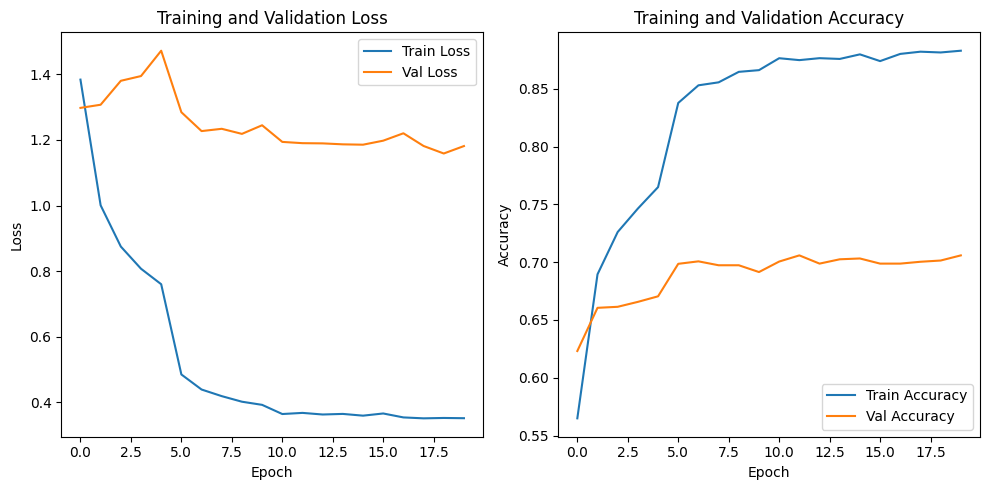

In [31]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)